# Product Category Clustering 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')


# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# Text processing
import re
from collections import Counter

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Load and Explore Data

In [2]:
# Load the dataset
# Update the file path to match your dataset location
df = pd.read_csv('..\\datasets\\processed\\final_dataset_sentiment_analysis.csv')  # or .json if using JSON format

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (59630, 27)

Columns: ['asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'id', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'name', 'primaryCategories', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sourceURLs']


,asins,brand,categories,dateAdded,dateUpdated,id,imageURLs,keys,manufacturer,manufacturerNumber,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs
0,B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,NaN,AVqkIhwDv8e3D1O-lebb,NaN,"841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,NaN,...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter,NaN
1,B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,NaN,AVqkIhwDv8e3D1O-lebb,NaN,"841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,NaN,...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman,NaN
2,B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,NaN,AVqkIhwDv8e3D1O-lebb,NaN,"841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,NaN,...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ,NaN
3,B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,NaN,AVqkIhwDv8e3D1O-lebb,NaN,"841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,NaN,...,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks,NaN
4,B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,NaN,AVqkIhwDv8e3D1O-lebb,NaN,"841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,NaN,...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42,NaN


## 3. Data Preprocessing

In [3]:
# Create a working copy
df_clean = df.copy()

# Handle missing values in text columns
text_columns = ['name', 'reviews.text', 'reviews.title', 'brand', 'categories']
text_columns = [col for col in text_columns if col in df_clean.columns]

for col in text_columns:
    df_clean[col] = df_clean[col].fillna('')
    


In [4]:
# Text preprocessing function
def clean_text(text):
    """Clean and normalize text for clustering"""
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply cleaning
for col in text_columns:
    df_clean[f'{col}_clean'] = df_clean[col].apply(clean_text)
    


In [5]:
# Combine relevant text fields for clustering
# Prioritize product name and categories, with review text as additional context

def create_clustering_text(row):
    """Combine text fields with appropriate weights for clustering"""
    parts = []
    
    # Product name (most important - repeat 3x)
    if 'name_clean' in row.index and row['name_clean']:
        parts.extend([row['name_clean']] * 3)
    
    # Brand (repeat 2x)
    if 'brand_clean' in row.index and row['brand_clean']:
        parts.extend([row['brand_clean']] * 2)
    
    # Categories (repeat 2x)
    if 'categories_clean' in row.index and row['categories_clean']:
        parts.extend([row['categories_clean']] * 2)
    
    # Review title
    if 'reviews.title_clean' in row.index and row['reviews.title_clean']:
        parts.append(row['reviews.title_clean'])
    
    # Review text (1x - provides context but shouldn't dominate)
    if 'reviews.text_clean' in row.index and row['reviews.text_clean']:
        # Use first 200 characters to avoid overwhelming signal
        parts.append(row['reviews.text_clean'][:200])
    
    return ' '.join(parts)

df_clean['clustering_text'] = df_clean.apply(create_clustering_text, axis=1)

# Remove rows with empty clustering text
df_clean = df_clean[df_clean['clustering_text'].str.len() > 10].reset_index(drop=True)

print(df_clean['clustering_text'].iloc[0][:300])

all new fire hd tablet hd display wi fi gb includes special offers magenta all new fire hd tablet hd display wi fi gb includes special offers magenta all new fire hd tablet hd display wi fi gb includes special offers magenta amazon amazon electronics ipad tablets all tablets fire tablets tablets com


## 4. Feature Extraction with TF-IDF

In [6]:
# Initialize TF-IDF Vectorizer
# Using optimized parameters for product clustering

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,           # Top 1000 most important terms
    min_df=5,                    # Term must appear in at least 5 documents
    max_df=0.7,                  # Ignore terms that appear in >70% of documents
    ngram_range=(1, 2),          # Use unigrams and bigrams
    stop_words='english',        # Remove common English stop words
    sublinear_tf=True            # Use logarithmic TF scaling
)

# Fit and transform the clustering text
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['clustering_text'])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample features: {list(feature_names[:20])}")


Sample features: ['aa', 'aa aaa', 'aa performance', 'aaa', 'aaa electronics', 'aaa health', 'aaa performance', 'able', 'absolutely', 'access', 'accessories', 'accessories amazon', 'accessories camera', 'accessories computers', 'accessories ereaders', 'accessories home', 'accessories ipod', 'accessories kindle', 'accessories kitchen', 'accessories power']


## 5. K-Means Clustering (k=5)

In [7]:
# K-Means clustering with k=5
n_clusters = 5

kmeans_final = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=20,              
    max_iter=500,           
    verbose=1
)

print(f"Fitting K-Means with {n_clusters} clusters...")
cluster_labels = kmeans_final.fit_predict(tfidf_matrix)

# Add cluster labels to dataframe
df_clean['cluster'] = cluster_labels

print(df_clean['cluster'].value_counts().sort_index())

Fitting K-Means with 5 clusters...
Initialization complete
Iteration 0, inertia 50305.08909008714.
Iteration 1, inertia 28984.31183976766.
Iteration 2, inertia 28944.619297082838.
Iteration 3, inertia 28941.88970539655.
Iteration 4, inertia 28941.252998591986.
Iteration 5, inertia 28941.24531936872.
Converged at iteration 5: center shift 3.287142769953471e-08 within tolerance 8.440234738091763e-08.
Initialization complete
Iteration 0, inertia 43738.79738203992.
Iteration 1, inertia 27287.846946948703.
Iteration 2, inertia 27250.467387091594.
Iteration 3, inertia 27246.30214542042.
Iteration 4, inertia 27245.500042641826.
Iteration 5, inertia 27245.426469242142.
Iteration 6, inertia 27245.42305523849.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 50588.53615566518.
Iteration 1, inertia 29227.680006810657.
Iteration 2, inertia 29189.96730439708.
Iteration 3, inertia 29170.72831246962.
Iteration 4, inertia 29170.45078740134.
Converged at iterat

In [8]:
# Calculate final clustering metrics
final_silhouette = silhouette_score(tfidf_matrix, cluster_labels)
final_davies_bouldin = davies_bouldin_score(tfidf_matrix.toarray(), cluster_labels)

print("\n" + "="*60)
print("FINAL CLUSTERING METRICS (k=5)")
print("="*60)
print(f"Silhouette Score:        {final_silhouette:.4f}  (Range: -1 to 1, higher is better)")
print(f"Davies-Bouldin Score:    {final_davies_bouldin:.4f}  (Lower is better)")
print("="*60)


FINAL CLUSTERING METRICS (k=5)
Silhouette Score:        0.3363  (Range: -1 to 1, higher is better)
Davies-Bouldin Score:    1.6581  (Lower is better)


## 6. Analyze and Name Clusters

In [9]:
# Extract top terms for each cluster
def get_top_terms_per_cluster(n_terms=15):
    """Extract the most important terms for each cluster"""
    
    cluster_terms = {}
    
    for cluster_id in range(n_clusters):
        # Get cluster center
        center = kmeans_final.cluster_centers_[cluster_id]
        
        # Get top feature indices
        top_indices = center.argsort()[-n_terms:][::-1]
        
        # Get feature names and scores
        top_terms = [(feature_names[i], center[i]) for i in top_indices]
        
        cluster_terms[cluster_id] = top_terms
    
    return cluster_terms

cluster_top_terms = get_top_terms_per_cluster(n_terms=20)

# Display top terms for each cluster
print("\n" + "="*80)
print("TOP TERMS PER CLUSTER")
print("="*80)

for cluster_id in range(n_clusters):
    print(f"\n CLUSTER {cluster_id} (n={len(df_clean[df_clean['cluster'] == cluster_id])})")
    print("-" * 80)
    
    terms = cluster_top_terms[cluster_id]
    top_15 = ', '.join([term for term, score in terms[:15]])
    print(f"Top terms: {top_15}")
    
    # Show sample product names if available
    if 'name' in df_clean.columns:
        sample_products = df_clean[df_clean['cluster'] == cluster_id]['name'].value_counts().head(5)
        print(f"\nSample products:")
        for product, count in sample_products.items():
            print(f"  • {product[:80]} ({count} reviews)")


TOP TERMS PER CLUSTER

 CLUSTER 0 (n=15362)
--------------------------------------------------------------------------------
Top terms: tablets, tablet display, fi gb, display wi, offers magenta, toys, tablet, magenta, tablets tablets, electronics tech, toys movies, tech toys, movies music, wi fi, fi

Sample products:
  • Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta (10751 reviews)
  • Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case (1663 reviews)
  • Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case (1485 reviews)
  • Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case (1438 reviews)
  • Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,,,
Amazon - Kindle Voyage - 4 (15 reviews)

 CLUSTER 1 (n=10852)
--------------------------------------------------------------------------------
Top terms: batteries, health, household, amazonbasics, health household, care, aaa, camera, alkaline, alkaline batter

In [10]:
# cluster naming based on top terms and products

cluster_names = {
    0: 'Kids Toys & kids entertainment',
    1: 'Batteries and household essentials',
    2: 'Amazon devices & accessories',
    3: 'Entertainment Appliances',
    4: 'Computers and electronics'
}

# Add cluster names to dataframe
df_clean['cluster_name'] = df_clean['cluster'].map(cluster_names)

print("\n📋 Cluster Names:")
for cluster_id, name in cluster_names.items():
    count = len(df_clean[df_clean['cluster'] == cluster_id])
    print(f"  Cluster {cluster_id}: {name} ({count} products)")


📋 Cluster Names:
  Cluster 0: Kids Toys & kids entertainment (15362 products)
  Cluster 1: Batteries and household essentials (10852 products)
  Cluster 2: Amazon devices & accessories (8737 products)
  Cluster 3: Entertainment Appliances (5069 products)
  Cluster 4: Computers and electronics (19610 products)


## 7. Visualize Clusters

In [11]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())

print(f" Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Add PCA components to dataframe
df_clean['pca_1'] = tfidf_2d[:, 0]
df_clean['pca_2'] = tfidf_2d[:, 1]

 Explained variance: 34.71%


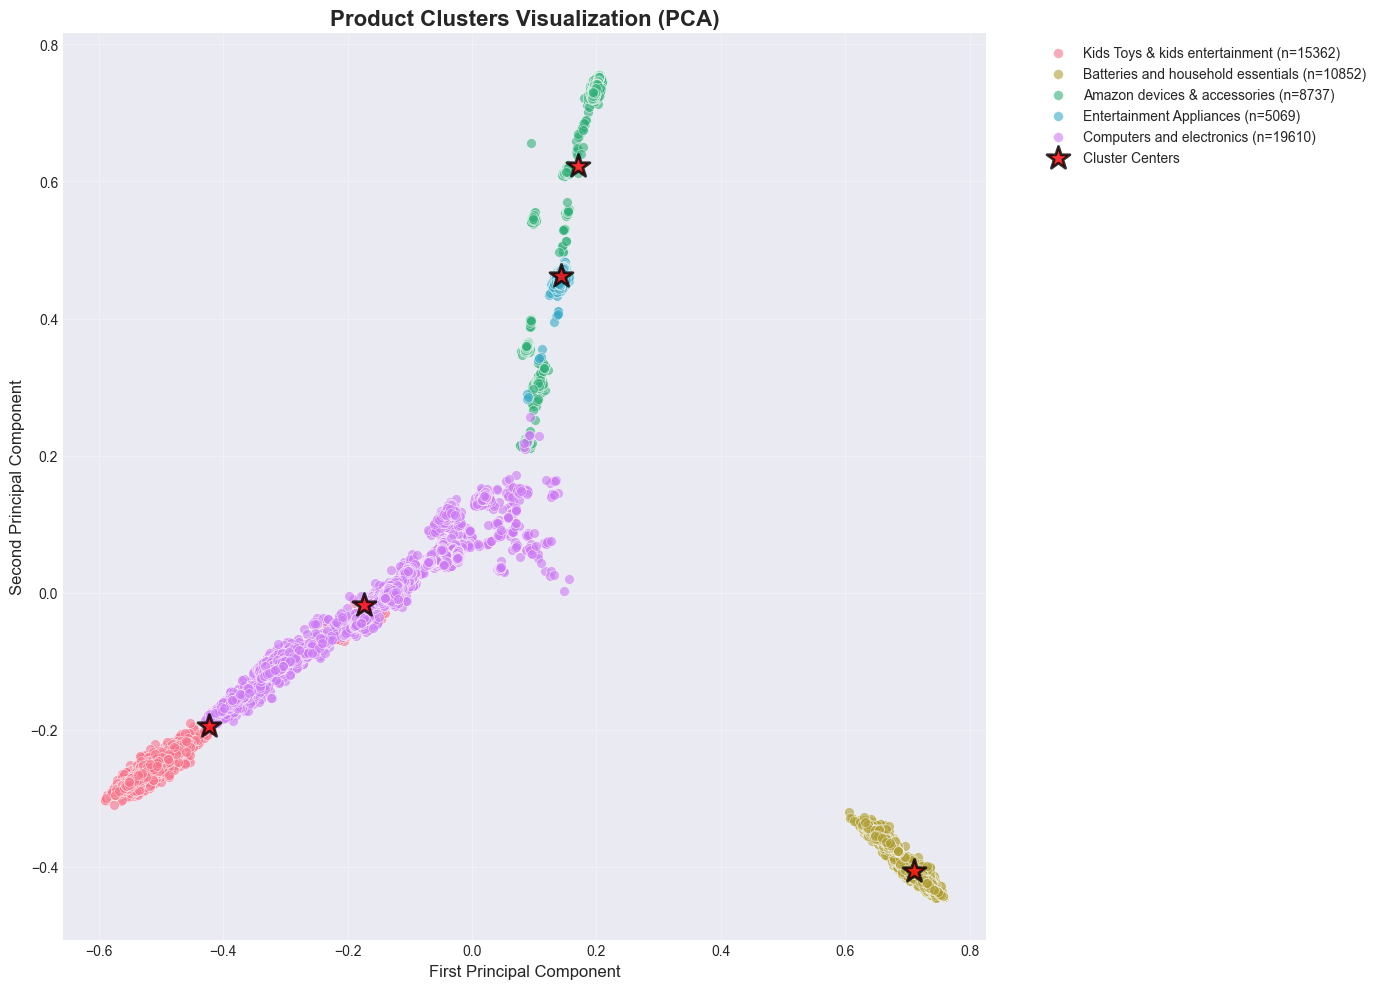

In [12]:
# 2D scatter plot of clusters
plt.figure(figsize=(14, 10))

# Create color palette
colors = sns.color_palette("husl", n_clusters)

for cluster_id in range(n_clusters):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    plt.scatter(
        cluster_data['pca_1'],
        cluster_data['pca_2'],
        c=[colors[cluster_id]],
        label=f"{cluster_names[cluster_id]} (n={len(cluster_data)})",
        alpha=0.6,
        s=50,
        edgecolors='white',
        linewidth=0.5
    )

# Plot cluster centers
centers_2d = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    c='red',
    s=300,
    alpha=0.8,
    edgecolors='black',
    linewidth=2,
    marker='*',
    label='Cluster Centers'
)

plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('Product Clusters Visualization (PCA)', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

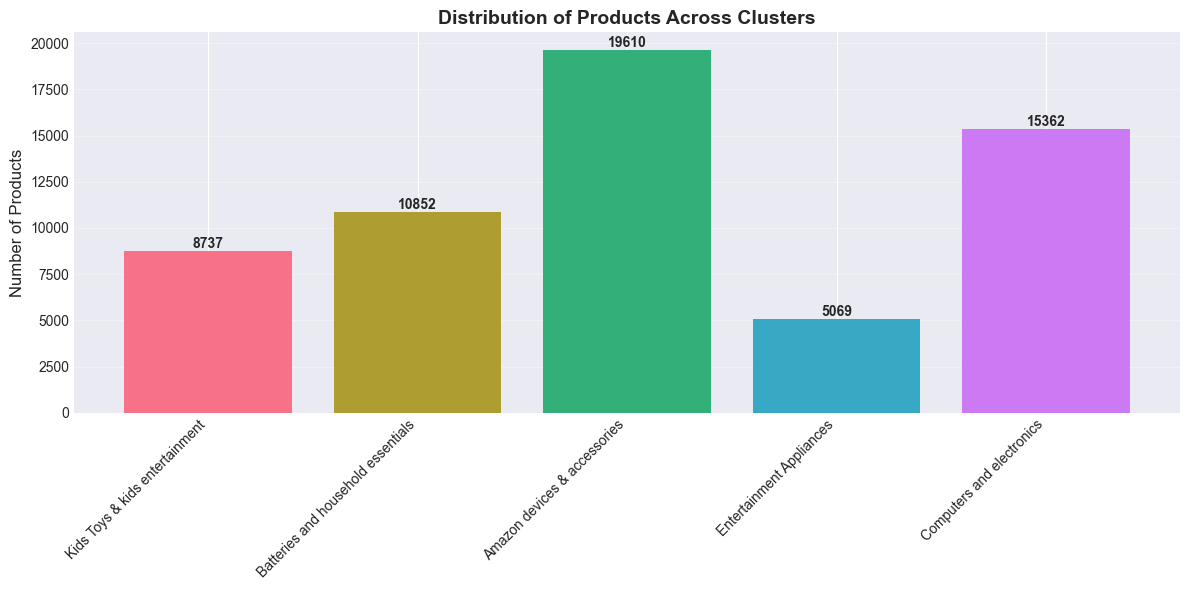

In [13]:
# Cluster size distribution
plt.figure(figsize=(12, 6))

cluster_counts = df_clean['cluster_name'].value_counts().sort_index()
bars = plt.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)
plt.xticks(range(len(cluster_counts)), 
           [cluster_names[i] for i in range(n_clusters)], 
           rotation=45, ha='right')
plt.ylabel('Number of Products', fontsize=12)
plt.title('Distribution of Products Across Clusters', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

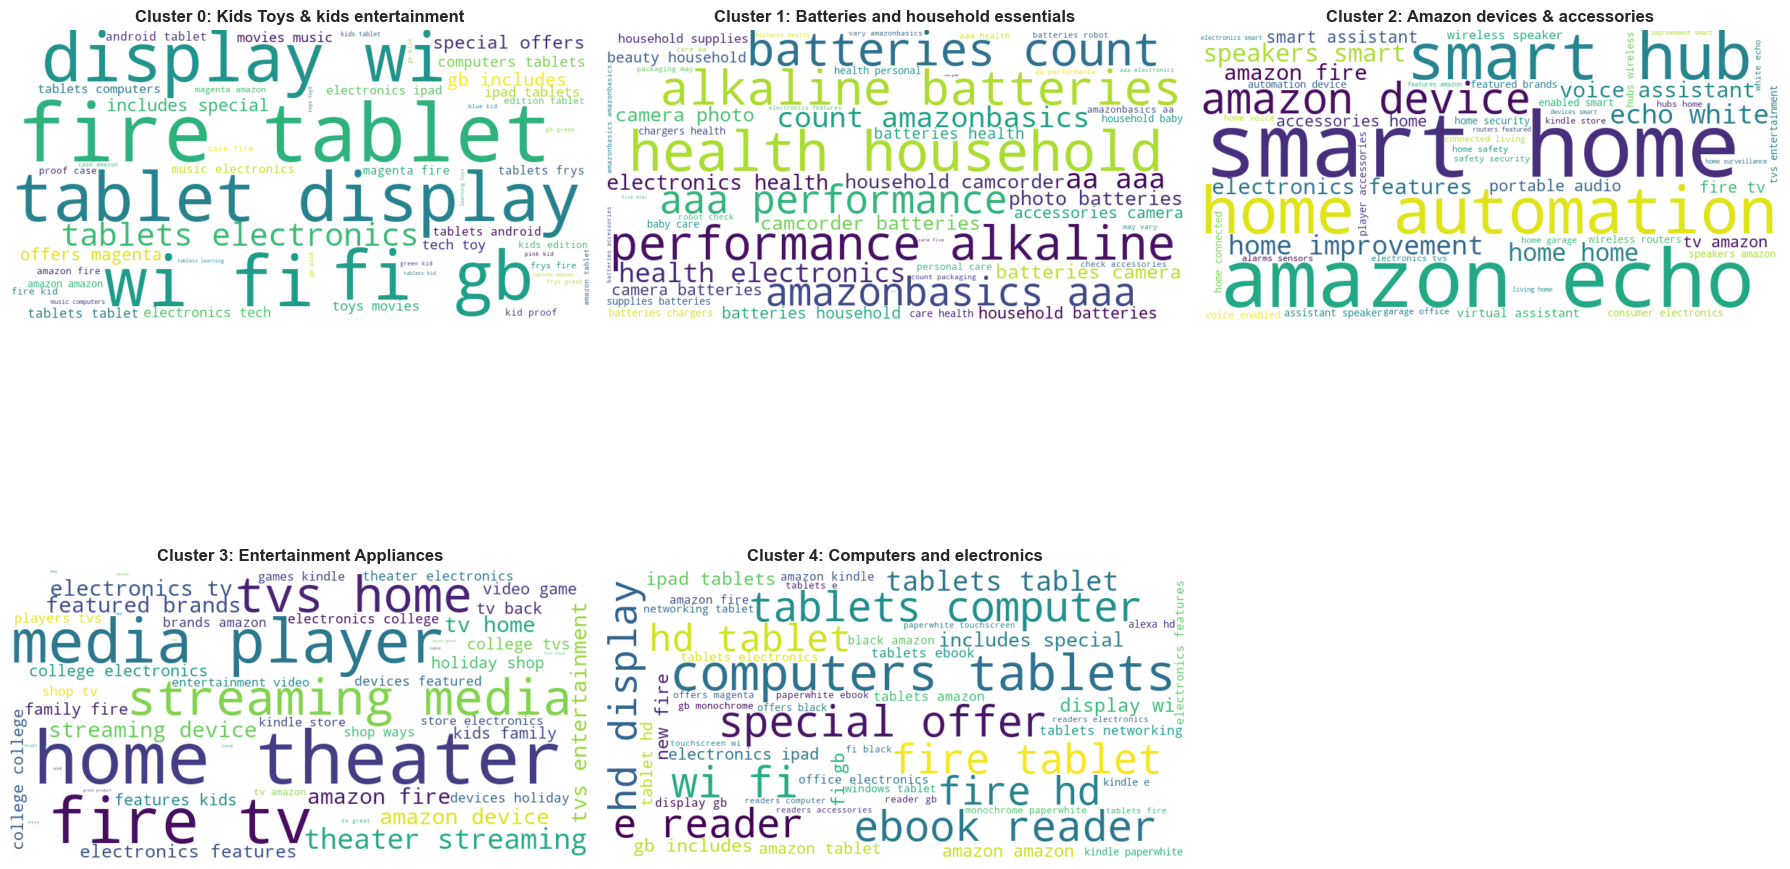

In [14]:
# Word clouds for each cluster
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for cluster_id in range(n_clusters):
    # Get all text for this cluster
    cluster_text = ' '.join(df_clean[df_clean['cluster'] == cluster_id]['clustering_text'])
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=50,
        relative_scaling=0.5
    ).generate(cluster_text)
    
    axes[cluster_id].imshow(wordcloud, interpolation='bilinear')
    axes[cluster_id].axis('off')
    axes[cluster_id].set_title(f'Cluster {cluster_id}: {cluster_names[cluster_id]}',
                               fontsize=12, fontweight='bold')

# Remove the extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 8. Cluster Statistics and Analysis

In [15]:
# Detailed cluster statistics
print("CLUSTER STATISTICS")


for cluster_id in range(n_clusters):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    
    print(f"CLUSTER {cluster_id}: {cluster_names[cluster_id]}")
    print(f"Size: {len(cluster_data)} products ({len(cluster_data)/len(df_clean)*100:.1f}%)")
    
    # Rating statistics if available
    if 'reviews.rating' in cluster_data.columns:
        print(f"\nRating Statistics:")
        print(f"  Mean rating: {cluster_data['reviews.rating'].mean():.2f}")
        print(f"  Median rating: {cluster_data['reviews.rating'].median():.2f}")
        print(f"  Std deviation: {cluster_data['reviews.rating'].std():.2f}")
    
    # Brand distribution if available
    if 'brand' in cluster_data.columns:
        top_brands = cluster_data['brand'].value_counts().head(5)
        if len(top_brands) > 0:
            print(f"\nTop 5 Brands:")
            for brand, count in top_brands.items():
                print(f"  • {brand}: {count} products")
    
    # Most reviewed products
    if 'name' in cluster_data.columns:
        top_products = cluster_data['name'].value_counts().head(3)
        print(f"\nMost Reviewed Products:")
        for product, count in top_products.items():
            print(f"  • {product[:60]}... ({count} reviews)")

CLUSTER STATISTICS
CLUSTER 0: Kids Toys & kids entertainment
Size: 15362 products (25.8%)

Rating Statistics:
  Mean rating: 4.48
  Median rating: 5.00
  Std deviation: 0.80

Top 5 Brands:
  • Amazon: 15362 products

Most Reviewed Products:
  • Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offer... (10751 reviews)
  • Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-... (1663 reviews)
  • Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-... (1485 reviews)
CLUSTER 1: Batteries and household essentials
Size: 10852 products (18.2%)

Rating Statistics:
  Mean rating: 4.41
  Median rating: 5.00
  Std deviation: 1.18

Top 5 Brands:
  • Amazonbasics: 10852 products

Most Reviewed Products:
  • AmazonBasics AAA Performance Alkaline Batteries (36 Count)... (7457 reviews)
  • AmazonBasics AA Performance Alkaline Batteries (48 Count) - ... (3395 reviews)
CLUSTER 2: Amazon devices & accessories
Size: 8737 products (14.7%)

Rating Statistics:
  Mean rating: 4.66
  Med

In [16]:
# summary dataframe for clusters
cluster_summary = pd.DataFrame({
    'Cluster_ID': range(n_clusters),
    'Cluster_Name': [cluster_names[i] for i in range(n_clusters)],
    'Size': [len(df_clean[df_clean['cluster'] == i]) for i in range(n_clusters)],
    'Percentage': [len(df_clean[df_clean['cluster'] == i])/len(df_clean)*100 for i in range(n_clusters)],
    'Top_Terms': [', '.join([term for term, _ in cluster_top_terms[i][:10]]) for i in range(n_clusters)]
})

print(" CLUSTER SUMMARY TABLE")
print(cluster_summary.to_string(index=False))

 CLUSTER SUMMARY TABLE
 Cluster_ID                       Cluster_Name  Size  Percentage                                                                                                            Top_Terms
          0     Kids Toys & kids entertainment 15362   25.762200 tablets, tablet display, fi gb, display wi, offers magenta, toys, tablet, magenta, tablets tablets, electronics tech
          1 Batteries and household essentials 10852   18.198893        batteries, health, household, amazonbasics, health household, care, aaa, camera, alkaline, alkaline batteries
          2       Amazon devices & accessories  8737   14.652021                 smart, home, echo, audio, smart home, speakers, amazon echo, automation, home automation, assistants
          3           Entertainment Appliances  5069    8.500755  streaming, college, home theater, theater, tv, streaming media, tvs home, media players, players, theater streaming
          4          Computers and electronics 19610   32.886131   

## 10. Export Results

In [22]:
# Export clustered dataset
output_columns = ['cluster', 'cluster_name']

# Add original columns
for col in df.columns:
    if col not in output_columns:
        output_columns.append(col)

# Create output dataframe
df_output = df_clean[output_columns].copy()


# Save cluster assignments only (for integration with other workflows)
cluster_assignments = df_clean[['cluster', 'cluster_name']].copy()
# cluster_assignments.to_csv('cluster_assignments.csv', index=False)
# print("✓ Saved: cluster_assignments.csv")


In [23]:
export_cols = [
    "reviews.id",
    "asins",
    "name",
    "reviews.text",
    "reviews.rating",
    "cluster",
    "cluster_name"
]
missing_cols = [col for col in export_cols if col not in df_clean.columns]

if missing_cols:
    print("Missing columns:", missing_cols)
else:
    print("All columns found ✓")

df_export = df_clean[export_cols].copy()

df_export.to_csv("..//datasets//processed//clustered_reviews_export.csv", index=False)
print("✓ Saved: clustered_reviews_export.csv")

All columns found ✓
✓ Saved: clustered_reviews_export.csv


In [18]:
df_output.columns

Index(['cluster', 'cluster_name', 'asins', 'brand', 'categories', 'dateAdded',
       'dateUpdated', 'id', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'primaryCategories', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs'],
      dtype='str')

In [19]:
# # Save model artifacts using joblib
# import joblib

# # Save the trained models
# joblib.dump(kmeans_final, 'kmeans_model.pkl')
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
# joblib.dump(pca, 'pca_model.pkl')
# joblib.dump(cluster_names, 'cluster_names.pkl')

# print("\n✓ Model artifacts saved:")
# print("  - kmeans_model.pkl")
# print("  - tfidf_vectorizer.pkl")
# print("  - pca_model.pkl")
# print("  - cluster_names.pkl")